# EU Emissions Per Capita

This notebook shows how to create a chart similar to the infographics showing [European emissions per capita](https://faktaoklimatu.cz/infografiky/emise-eu-na-osobu):

![EU emissions per capita](https://faktaoklimatu.cz/assets/infographics/emise-eu-na-osobu_1200.png)

The width of each rectangle shows a population of a given country, the height shows the emissions per capita. As the overall country emissions are given by the product of these variables, the area of each rectangle shows the total emissions.

## Load prerequisities

It is necessary to install all the required packages before the first use (and it has to be done only once for all notebooks). Then we can import the libraries (and set up better plotting settings via matplotlibrc file).

In [ ]:
!pip install -r requirements.txt

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc_file_defaults()
import eurostat

## Prepare the dataset

Now we can create the dataset with all the underlying data. It consists of two parts:
- population data
- greenhouse gases emissions data

Both these datasets are available via Eurostat, so we can use their library to load it easily. In addition, we also need a list of all countries we want to include into the plot. As the country names can be written in different ways (i.e. Czechia or The Czech Republic), it is better to use standardised ISO 3166 codes as country identifiers – and that's also what Eurostat datasets use. The chart shows EU28 countries, so European Union still including United Kingdom.

If you care only about the chart, you can skip this section and just load the dataset from a file in the next part.

In [2]:
# country codes for EU28 based on ISO 3166 alpha-2
eu28 = ['AT', 'BE', 'BG', 'CY', 'CZ', 'DE', 'DK', 'EE', 'EL', 'ES', 'FI', 'FR', 'HR', 'HU',
        'IE', 'IT', 'LT', 'LU', 'LV', 'MT', 'NL', 'PL', 'PT', 'RO', 'SE', 'SI', 'SK', 'UK']

In [3]:
# geo dictionary allows us to easily convert ISO codes into country names
geo_dic = eurostat.get_dic('geo')

In [4]:
# create a dataframe with all EU countries and with a sane name for Germany
df = pd.DataFrame({'code': eu28, 'country': [geo_dic[c] if c != 'DE' else 'Germany' for c in eu28]})

Now we can load **population data** – the full dataset contains also population for different age groups and for men and women, so we subset only on totals.

In [5]:
pop_raw = eurostat.get_data_df('demo_pjan', flags=False).query('age == "TOTAL" and sex == "T"')

In [6]:
pop = pop_raw[[r'geo\time', 2018]].rename(columns={r'geo\time': 'code', 2018: 'pop'})
pop['pop'] = np.int_(pop['pop'])

Load **greenhouse gases table** and filter on:
- airpol == GHG means all greenhouse gases, expressed as CO2 equivalent,
- src_crf == TOTX4_MEMONIA means total emissions, excluding LULUCF and memo items, including international aviation,
- unit == MIO_T means the values are expressed in million tonnes.


In [7]:
ghg_raw = eurostat.get_data_df('env_air_gge', flags=False) \
    .query('airpol == "GHG" and src_crf == "TOTX4_MEMONIA" and unit == "MIO_T"')

In [8]:
ghg = ghg_raw[[r'geo\time', 2018]].rename(columns={r'geo\time': 'code', 2018: 'ghg'})

The last step is to merge the datasets together and create an additional column for emissions per capita (and we multiply by 1e6, so the values are in metric tonnes per capita).

In [9]:
df = pd.merge(pd.merge(df, pop), ghg)

In [10]:
# emissions per capita, in tonnes per capita per year
df['ghg_per_capita'] = 1e6 * df['ghg'] / df['pop']

The resulting dataset is identical to `data/eu-emissions-2018.csv`.

In [11]:
# df.to_csv('../data/eu-emissions-2018.csv', index=False)
df

,code,country,pop,ghg,ghg_per_capita
0,AT,Austria,8822267,81.50147,9.238155
1,BE,Belgium,11398589,123.64290,10.847211
2,BG,Bulgaria,7050034,58.59507,8.311317
3,CY,Cyprus,864236,9.85631,11.404651
4,CZ,Czechia,10610055,129.38768,12.194817
5,DE,Germany,82792351,888.71856,10.734308
6,DK,Denmark,5781190,51.29975,8.873562
7,EE,Estonia,1319133,20.18452,15.301353
8,EL,Greece,10741165,96.11319,8.948116
9,ES,Spain,46658447,352.20855,7.548656


## Plot the results

We can just load the dataset from the file – it is identical to the one created in the previous section. 

In [12]:
df = pd.read_csv('../data/eu-emissions-2018.csv')

The visualization uses five colors for the rectangles, based on the total emissions of a given country.

In [13]:
color_schema = ['#7FCCBA', '#41B5C3', '#1D90BF', '#225EA7', '#0C2C83']

We create another column in the dataframe, telling us into which group based on total emissions a country belongs. The original infographics (version 1.1) is based on data for 2016, so the charts will be slightly different anyway – we also use slightly different cutoff values here, just to have them a nicer numbers.

In [14]:
cutoffs = [0, 15, 50, 100, 250, df.ghg.max() + 1]
df['group'] = pd.cut(df.ghg, cutoffs, labels=False)

The last step is just to show all data. We will start with an empty chart and will add the countries consecutively, starting with the highest per capita emissions. There is also a small horizontal offset between the neighboring countries, hence the values on x-axis are just approximate (and that is also the reason why the x-axis population values are not displayed on the infographics).

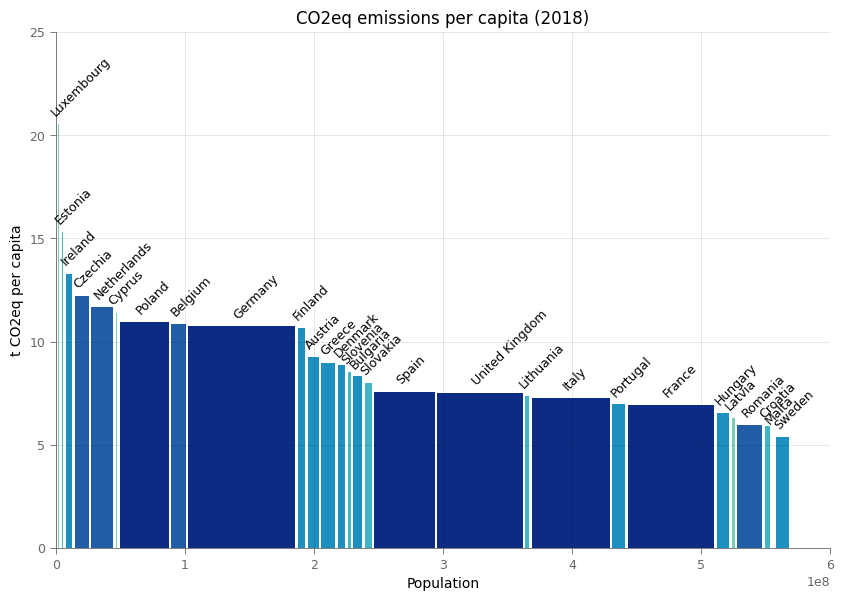

In [15]:
fig, ax = plt.subplots()

x = 0
xgap = 2e6
ygap = 0.4

for i, row in df.sort_values('ghg_per_capita', ascending=False).iterrows():
    x = x + xgap
    plt.text(x + 0.5 * row['pop'] - 4 * xgap, row['ghg_per_capita'] + ygap, row['country'], rotation=45, fontsize=9)
    rec = mpl.patches.Rectangle((x, 0), row['pop'], row['ghg_per_capita'], ec=None, fc=color_schema[row['group']])
    ax.add_patch(rec)
    x = x + row['pop']

ax.set(xlim=(0, 6e8), ylim=(0, 25))
ax.set(xlabel='Population', ylabel='t CO2eq per capita', title='CO2eq emissions per capita (2018)')

plt.show()

Matplotlib also allows to save the chart as PDF or SVG. These vector formats can then be loaded into a specialized graphic software such as Illustrator or Inkscape to turn them into a nice, proper visualization that can be found on our website.